In [ ]:
import os
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn imports
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# Classical models
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

# Neural network (Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2

from itertools import product

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Dataset

## Load Dataset

In [28]:
summer_data_path = 'data/data_3dcp_sClean.csv'
winter_data_path = 'data/data_3dcp_wClean.csv'

summer_data = pd.read_csv(summer_data_path)
winter_data = pd.read_csv(winter_data_path)
concat_data = pd.concat([summer_data, winter_data], axis=0)

data = winter_data

## Train-Test Split

In [29]:
# Define features and target
X = data[['extrusion', 'layer_height', 'layer_width']]
y = data['speed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (512, 3)
Test set shape: (128, 3)


# Neural Network Model

In [30]:
K_FOLD = False

BATCH_SIZE = 63

TRAIN_MODEL = True
SAVE_MODEL = False
LOAD_MODEL = False

SAVE_DIR = 'model'
FILE_NAME = '3DCP_wANN'

## ANN Model

In [31]:
def create_nn_model(input_dim, model_depth=2, layer_size=32, l1_rate=1e-3, l2_rate=1e-3, dropout_rate=0.0, learning_rate=1e-2):
    model = Sequential()

    model.add(Input((input_dim,)))

    for _ in range(model_depth):
        model.add(Dense(layer_size, activation='elu',
                        kernel_regularizer=l1_l2(l1_rate, l2_rate)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1))
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

## K-fold Cros-Validation

In [32]:
if K_FOLD:
    # Set up KFold cross-validation for the NN
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    nn_cv_metrics = []
    fold = 1

    for train_index, val_index in kf.split(X_train):
        # Split the training set into fold-specific training and validation sets
        X_tr_fold = X_train.iloc[train_index]
        X_val_fold = X_train.iloc[val_index]
        y_tr_fold = y_train.iloc[train_index]
        y_val_fold = y_train.iloc[val_index]
        
        scaler_nn = RobustScaler()
        X_tr_fold_scaled = scaler_nn.fit_transform(X_tr_fold)
        X_val_fold_scaled = scaler_nn.transform(X_val_fold)
        
        # Build and train the NN model
        model_nn = create_nn_model(input_dim=X_tr_fold_scaled.shape[1])
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=0)
        
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5, verbose=0)
        
        history = model_nn.fit(X_tr_fold_scaled, y_tr_fold, epochs=250, batch_size=BATCH_SIZE, verbose=0,
                            validation_data=(X_val_fold_scaled, y_val_fold), callbacks=[reduce_lr, early_stopping])
        
        # Evaluate the model on the validation fold
        y_val_pred = model_nn.predict(X_val_fold_scaled, verbose=0)
        
        mse_fold = mean_squared_error(y_val_fold, y_val_pred)
        mae_fold = mean_absolute_error(y_val_fold, y_val_pred)
        rmse_fold = np.sqrt(mse_fold)
        r2_fold = r2_score(y_val_fold, y_val_pred)
        
        # Store metrics for this fold
        fold_metrics = {'mse': mse_fold, 'mae': mae_fold, 'rmse': rmse_fold, 'r2': r2_fold}
        nn_cv_metrics.append(fold_metrics)
        
        # Print metrics for this fold
        print(f"Fold {fold} Neural Network Validation Metrics:")
        print(f"  MSE:  {mse_fold:.3f}, MAE:  {mae_fold:.3f}, RMSE: {rmse_fold:.3f}, R2:   {r2_fold:.3f}")
        print("---------------------")
        fold += 1

    # Compute average metrics across folds
    avg_mse = np.mean([m['mse'] for m in nn_cv_metrics])
    avg_mae = np.mean([m['mae'] for m in nn_cv_metrics])
    avg_rmse = np.mean([m['rmse'] for m in nn_cv_metrics])
    avg_r2 = np.mean([m['r2'] for m in nn_cv_metrics])

    print("\nAverage Neural Network Validation Metrics (5-Fold CV):")
    print(f"    MSE: {avg_mse:.3f}, MAE: {avg_mae:.3f}, RMSE: {avg_rmse:.3f}, R2: {avg_r2:.3f}")

## Train Model

In [33]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

nn = create_nn_model(input_dim=X_train_scaled.shape[1])
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=0)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, min_lr=1e-5, verbose=0)

if TRAIN_MODEL:
    history = nn.fit(X_train_scaled, y_train, epochs=1000, batch_size=BATCH_SIZE, verbose=2,
                                validation_split=0.2, callbacks=[reduce_lr, early_stopping])

Epoch 1/1000
7/7 - 1s - 113ms/step - loss: 46221.7031 - val_loss: 46146.9961 - learning_rate: 0.0100
Epoch 2/1000
7/7 - 0s - 13ms/step - loss: 44398.0117 - val_loss: 43614.9219 - learning_rate: 0.0100
Epoch 3/1000
7/7 - 0s - 12ms/step - loss: 40952.8594 - val_loss: 39030.4180 - learning_rate: 0.0100
Epoch 4/1000
7/7 - 0s - 12ms/step - loss: 34998.9102 - val_loss: 32070.9707 - learning_rate: 0.0100
Epoch 5/1000
7/7 - 0s - 12ms/step - loss: 26905.4375 - val_loss: 23474.5273 - learning_rate: 0.0100
Epoch 6/1000
7/7 - 0s - 12ms/step - loss: 18159.4863 - val_loss: 15908.9043 - learning_rate: 0.0100
Epoch 7/1000
7/7 - 0s - 12ms/step - loss: 12154.5088 - val_loss: 12270.2432 - learning_rate: 0.0100
Epoch 8/1000
7/7 - 0s - 12ms/step - loss: 10233.6660 - val_loss: 10047.7285 - learning_rate: 0.0100
Epoch 9/1000
7/7 - 0s - 12ms/step - loss: 8214.4072 - val_loss: 7598.9478 - learning_rate: 0.0100
Epoch 10/1000
7/7 - 0s - 12ms/step - loss: 6623.1875 - val_loss: 6278.2124 - learning_rate: 0.0100
Ep

## Save/Load Model and Scaler (Optional)

In [34]:
if SAVE_MODEL:
    os.makedirs(SAVE_DIR, exist_ok=True)

    # Save the complete Keras model in .keras format (this includes weights, architecture, and optimizer state)
    nn.save(f"{SAVE_DIR}/{FILE_NAME}_model.keras")

    # Save the scaler using joblib
    joblib.dump(scaler, f"{SAVE_DIR}/{FILE_NAME}_scaler.pkl")

    print("Model and Scaler saved successfully!")
else:
    print("Skipped saving Model and Scaler.")

Skipped saving Model and Scaler.


In [35]:
if LOAD_MODEL:
    nn = load_model(f"{SAVE_DIR}/{FILE_NAME}_model.keras")
    scaler = joblib.load(f"{SAVE_DIR}/{FILE_NAME}_scaler.pkl")

    print("Model and Scaler loaded successfully!")
else:
    print("Skipped loading Model and Scaler.")

Skipped loading Model and Scaler.


## Plot Residiuals (Predicted-Observed)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Final Neural Network Test Set Performance:
R²: 0.9928, MSE: 72.7832, RMSE: 8.5313, MAE: 6.2160, 


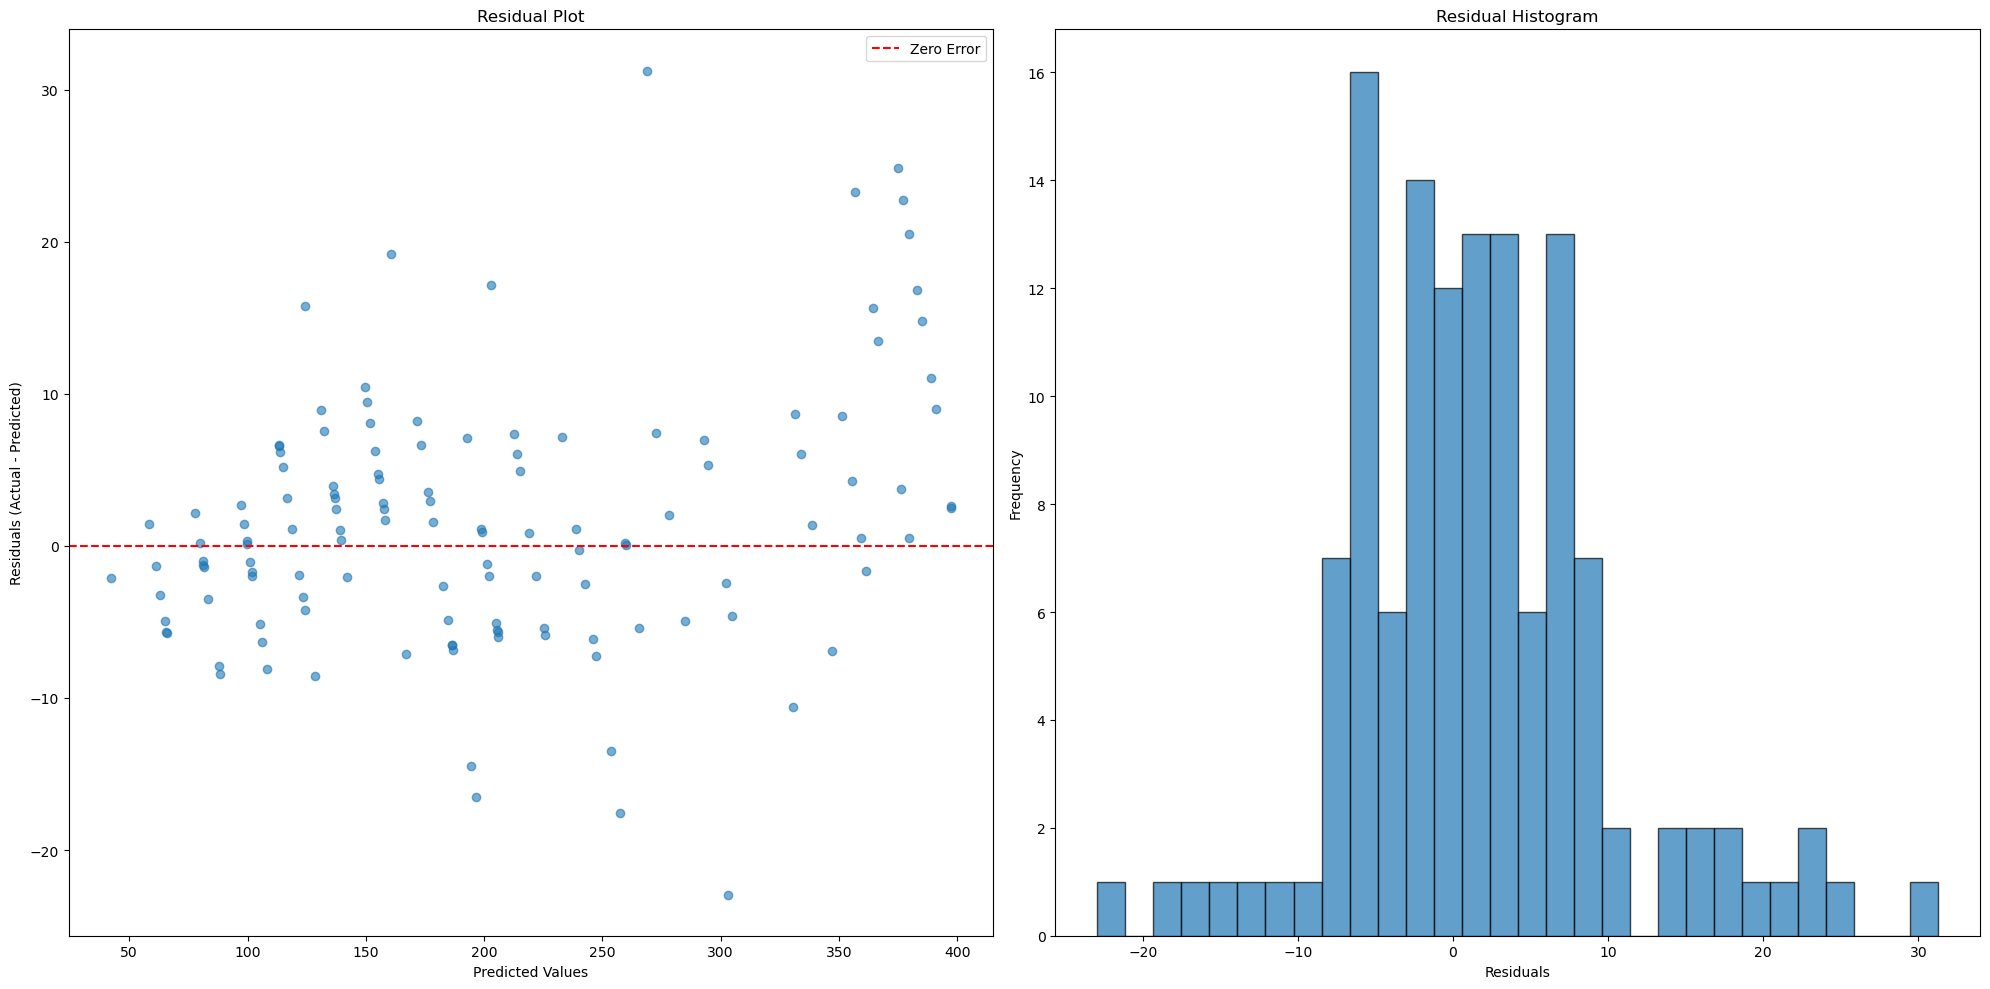

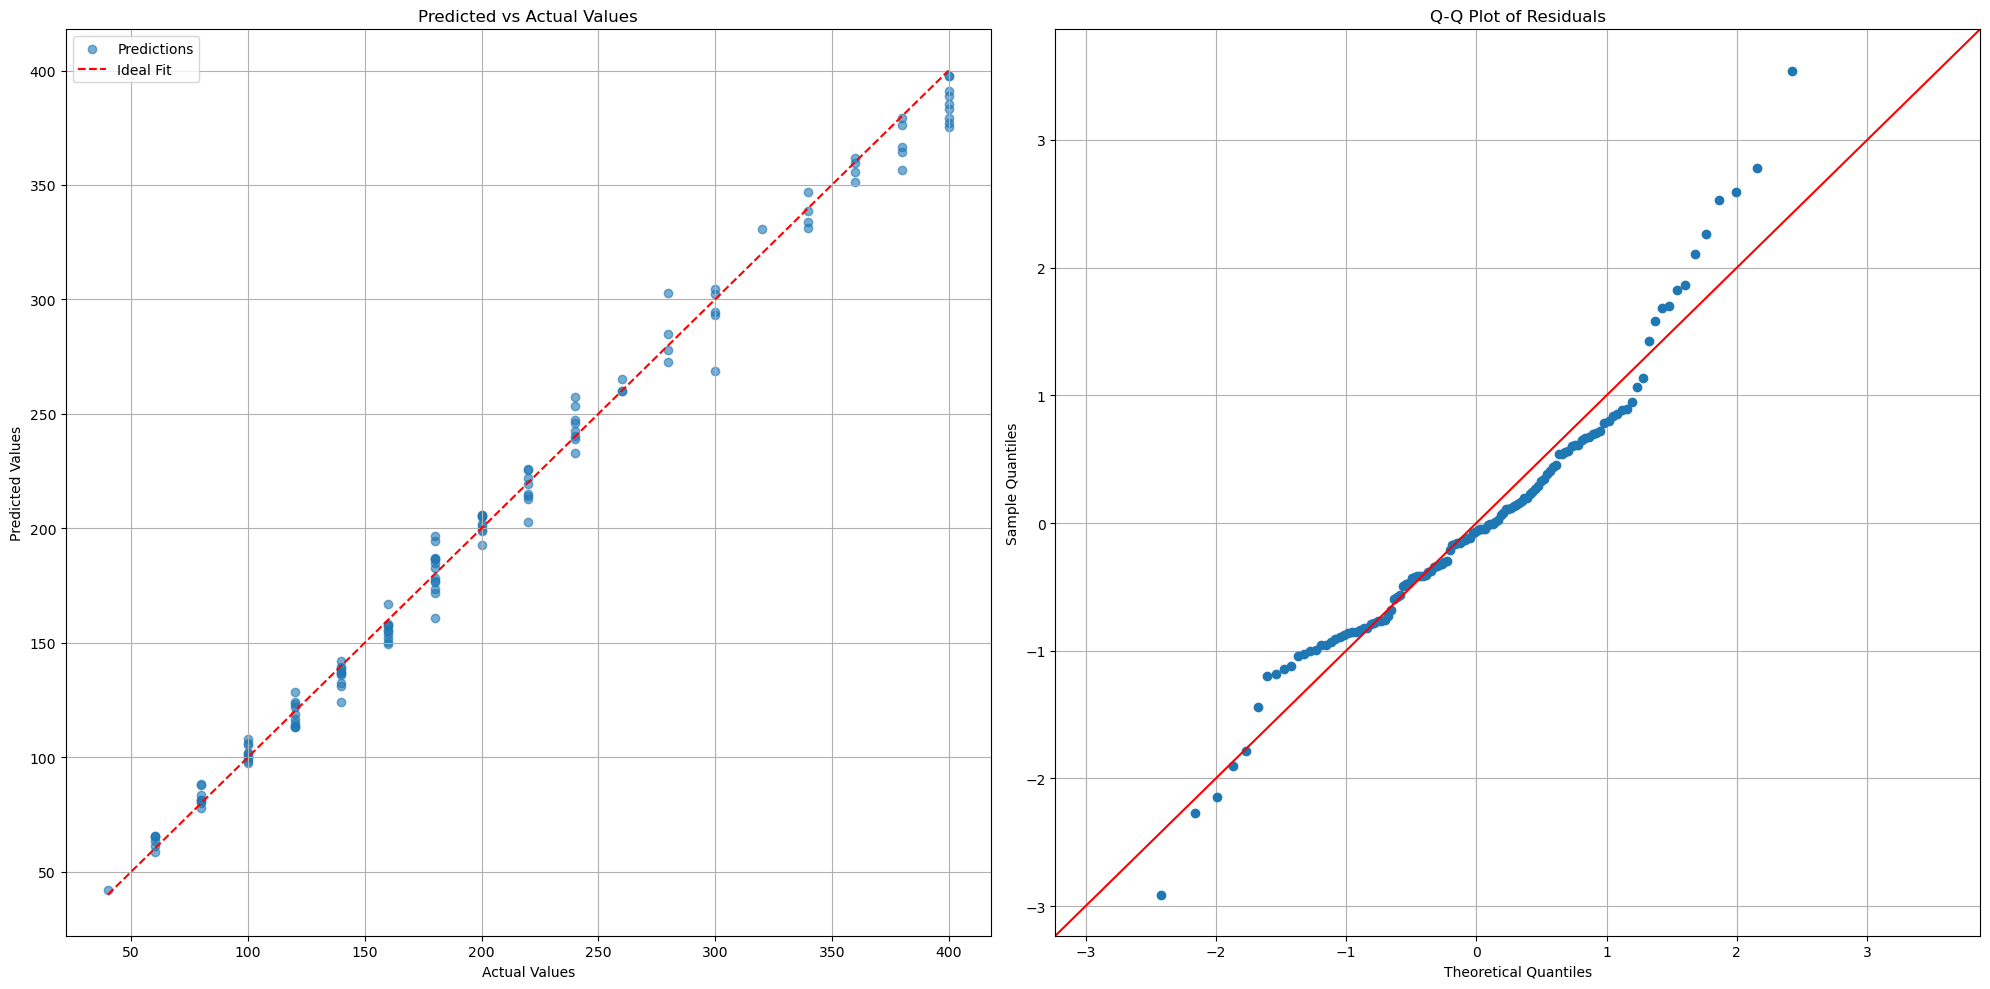

In [36]:
# Evaluate on the test set
y_test_pred = nn.predict(X_test_scaled)
r2  = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = root_mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)

print("\nFinal Neural Network Test Set Performance:")
print(f"R²: {r2:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, ")

# Compute residuals: ensure y_test_pred is a 1D array
residuals = y_test - y_test_pred.flatten()

plt.figure(figsize=(20, 10))

# Residual scatter plot
plt.subplot(1, 2, 1)
plt.scatter(y_test_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', label="Zero Error")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.legend()

# Residual histogram
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Histogram")

plt.tight_layout()
plt.show()

import statsmodels.api as sm

# Ensure y_test_pred is 1D
y_pred = y_test_pred.flatten()

# Compute residuals
residuals = y_test - y_pred

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# 1. Predicted vs Actual (Parity) Plot on the first subplot
axs[0].scatter(y_test, y_pred, alpha=0.6, label="Predictions")
axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Ideal Fit")
axs[0].set_xlabel("Actual Values")
axs[0].set_ylabel("Predicted Values")
axs[0].set_title("Predicted vs Actual Values")
axs[0].legend()
axs[0].grid(True)

# 2. Q-Q Plot of the residuals on the second subplot
sm.qqplot(residuals, line='45', fit=True, ax=axs[1])
axs[1].set_title("Q-Q Plot of Residuals")
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [37]:
# # Define the search grid ranges
# layer_height_range = [5, 8, 10, 12, 15, 18]
# layer_width_range  = np.linspace(15, 50, num=6)
# extrusion_values   = [5, 10]

# # Create the Cartesian product
# grid = list(product(extrusion_values, layer_height_range, layer_width_range))
# search_grid = pd.DataFrame(grid, columns=['extrusion', 'layer_height', 'layer_width'])

# # Scale the grid data using the final scaler
# search_grid_scaled = scaler.transform(search_grid)

# # Predict speed with the final NN model
# grid_predictions = nn.predict(search_grid_scaled)
# search_grid['speed'] = np.round(grid_predictions).astype(int)

# display(search_grid)

# if SAVE_MODEL:
#     search_grid.to_csv(f"{SAVE_DIR}/{FILE_NAME}_validation.csv", index=False)

In [38]:
# =============================================================================
# (1) Train Classical Models
# =============================================================================
# --- Standard Linear Regression ---
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)

# --- Log-Transformed Linear Regression ---
y_train_log = np.log(y_train)
log_lin_reg = LinearRegression()
log_lin_reg.fit(X_train, y_train_log)
y_pred_log_lin = np.exp(log_lin_reg.predict(X_test))

# --- Polynomial Regression (2nd degree) ---
poly_reg = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('lin', LinearRegression())
])
poly_reg.fit(X_train, y_train)
y_pred_poly = poly_reg.predict(X_test)

# =============================================================================
# (2) ANN Predictions
# =============================================================================
# (Assuming your ANN model 'nn' and scaler 'scaler' have been defined, trained, and loaded)
X_test_scaled = scaler.transform(X_test)
y_pred_ann = nn.predict(X_test_scaled).flatten()

# =============================================================================
# (3) Math Formula Predictions
# =============================================================================
# Define a helper function to compute math formula predictions for each sample.
def compute_math_predictions(df, extrusions, flowrates):
    preds = []
    for _, row in df.iterrows():
        f = row["extrusion"]
        h = row["layer_height"]
        w = row["layer_width"]
        # Compute prediction using the math formula
        pred = (f * 1e6) / (60 * ((w * h) - (h**2) + ((h**2) * np.pi / 4)))
        preds.append(pred)
    return np.array(preds)

# Compute math formula predictions using the test set.
# Assuming that the test set has the columns: 'extrusion', 'layer_height', 'layer_width'
y_pred_math = compute_math_predictions(X_test, extrusions=[5, 10], flowrates=[2, 3])

# =============================================================================
# (4) Compute and Print Performance Metrics
# =============================================================================
# Create a dictionary of predictions for the models we are comparing.
models = {
    'Linear Regression': y_pred_lr,
    'log-transformed LR': y_pred_log_lin,
    'Polynomial Regression': y_pred_poly,
    'Math Formula': y_pred_math,
    'ANN': y_pred_ann
}

metrics = {}
print("Model Performance Comparison:")
for name, y_pred in models.items():
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    metrics[name] = {"R2": r2, "MSE": mse, "RMSE": rmse, "MAE": mae}
    print(f"{name:>25}: R2: {r2:.4f}, RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}")

# =============================================================================
# (5) Plot Each Metric in Separate Subplots
# =============================================================================
# Convert the metrics dictionary into a DataFrame.
metrics_df = pd.DataFrame(metrics).T.reset_index().rename(columns={'index': 'Model'})
metric_names = ['R2', 'MSE', 'RMSE', 'MAE']

fig, axs = plt.subplots(2, 2, figsize=(20, 20))
for ax, metric in zip(axs.flatten(), metric_names):
    sns.barplot(data=metrics_df, x='Model', y=metric, ax=ax)
    ax.set_title(metric)
    ax.set_ylabel(metric)
    ax.set_xlabel("Model")
plt.tight_layout()
plt.show()

# =============================================================================
# (6) Plot Predicted vs Actual Values for Each Model in Separate Subplots
# =============================================================================
fig, axs = plt.subplots(3, 2, figsize=(20, 30))  # 3 rows x 2 columns to accommodate 5 models
model_names = list(models.keys())
all_axes = axs.flatten()

for idx, model_name in enumerate(model_names):
    ax = all_axes[idx]
    y_pred = models[model_name]
    # Scatter plot of actual vs. predicted values
    ax.scatter(y_test, y_pred, color='blue', alpha=0.6, label='Data Points')
    
    # Plot the ideal fit line (where predicted equals actual)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Fit')
    
    ax.set_title(f"{model_name} - Predicted vs. Actual")
    ax.set_xlabel("Actual Speed")
    ax.set_ylabel("Predicted Speed")
    ax.legend()

# Hide any extra subplot (if any)
for ax in all_axes[len(model_names):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

NameError: name 'PolynomialFeatures' is not defined

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

def plot_speed_vs_width_interpolation(
    nn_model,
    scaler,
    main_heights=[5, 8, 12, 15],
    extrusions=[2, 3],
    w_min=10,
    w_max=150,
    w_points=100,
    data_points=None  # Optional: DataFrame with actual data
):
    """
    For each extrusion value, this function:
      1. Draws faint gray prediction curves for every integer layer height from 5 to 14.
      2. Draws colored prediction curves for the specified 'main_heights'.
      3. Overlays a mathematical model prediction using:
             speed = (flowrate*1e6) / (60 * ((w * h) - h**2 + ((h**2)*pi/4)))
         where flowrate is provided in the `flowrates` list (corresponding to each extrusion).
      4. Optionally overlays actual data points if a DataFrame is provided.
    """
    # Generate a range of widths
    widths = np.linspace(w_min, w_max, w_points)

    # Create subplots: one subplot per extrusion value
    n_extrusions = len(extrusions)
    fig_h = 10
    fig, axes = plt.subplots(1, n_extrusions, figsize=(fig_h * n_extrusions, fig_h), sharey=True)

    # Define all layer heights for the gray curves (5 to 14 inclusive)
    all_heights = range(5, 15)

    for ax, e in zip(axes, extrusions):
        # -----------------------------
        # 1. Plot faint gray lines for every integer height in [5..14]
        # -----------------------------
        for h in all_heights:
            # Build the input array: columns = [layer_height, layer_width, extrusion]
            X = np.column_stack([
                np.full_like(widths, h),
                widths,
                np.full_like(widths, e)
            ])
            # Convert to DataFrame in the order the scaler expects
            X_df = pd.DataFrame(X, columns=["layer_height", "layer_width", "extrusion"])
            X_df = X_df[scaler.feature_names_in_]
            
            # Scale the inputs and predict speed
            X_scaled = scaler.transform(X_df)
            predicted_speed = nn_model.predict(X_scaled, verbose=0).flatten()

            # Plot in gray for a faded background effect
            # ax.plot(predicted_speed, widths, color='gray', alpha=0.3)

        # -----------------------------
        # 2. Plot main heights in color and overlay math model predictions
        # -----------------------------
        for i, h in enumerate(main_heights):
            color = f"C{i}"
            # Neural network predictions
            X = np.column_stack([
                np.full_like(widths, h),
                widths,
                np.full_like(widths, e)
            ])
            X_df = pd.DataFrame(X, columns=["layer_height", "layer_width", "extrusion"])
            X_df = X_df[scaler.feature_names_in_]
            
            X_scaled = scaler.transform(X_df)
            predicted_speed = nn_model.predict(X_scaled, verbose=0).flatten()

            # Plot NN predictions in color
            ax.plot(predicted_speed, widths, label=f"NN: Height={h} mm", color=color)

            # Overlay actual data points if provided
            if data_points is not None:
                subset = data_points[
                    (data_points["extrusion"] == e) & (data_points["layer_height"] == h)
                ]
                if not subset.empty:
                    # Define a mapping for marker shapes based on 'over-under' values
                    marker_mapping = {-1: 'v', 0: 'o', 1: '^'}
                    
                    # Iterate over each marker shape and plot the corresponding subset of points
                    for value, marker in marker_mapping.items():
                        group = subset[subset["over-under"] == value]
                        if not group.empty:
                            ax.scatter(
                                group["speed"],
                                group["layer_width"],
                                color=color,
                                marker=marker,
                                edgecolor='black',
                                alpha = .5,
                                s=50
                            )
            
            # -----------------------------
            # 3. Overlay mathematical model predictions (using flowrate from the flowrates list)
            # -----------------------------
            # Compute speeds for each width value using the math model:
            math_speeds = ((e) * 1e6) / (60 * ((widths * h) - (h**2) + ((h**2) * np.pi / 4)))
            ax.plot(math_speeds, widths, linestyle='--', color=color, label=f"Formula: Height={h} mm")

        ax.set_xlabel("Robot Speed")
        ax.set_title(f"Extrusion = {e} L/s")
        ax.set_xlim(0, 500)
        ax.set_ylim(w_min, w_max)
        ax.grid(True)
        ax.legend()

    axes[0].set_ylabel("Layer Width (mm)")
    fig.suptitle("ML Model Predictions: Speed vs. Width (Interpolated Layer Heights)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Example usage:
plot_speed_vs_width_interpolation(
    nn_model=nn,
    scaler=scaler,
    main_heights=[5, 8, 10, 12, 15, 18],
    extrusions=[2, 3],
    w_min=10,
    w_max=80,
    w_points=100,
    data_points=data.groupby(['layer_height', 'extrusion', 'speed'], as_index=False)['layer_width'].mean()
)

NameError: name 'nn' is not defined